In [5]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange

import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1


    
    

def iter_list(log_dir):
    dirlist = os.listdir(log_dir)
    iterlist = []
    for mydir in dirlist:
        if 'iter' in mydir and 'tmp' not in mydir:
            iterlist.append(int(mydir.split('_')[-1]))
    return np.array(iterlist)
    
    
def load_model(model, log_dir, iters, latest=False):
    print(f"""{log_dir} \n snapshot_model_iter_{iters}""")
    if latest == True:
        iters = np.max(iter_list(log_dir))
    model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_model_iter_{}'.format(iters))))



def load_config(targdir_path):
    targ_config_path = os.path.join(targdir_path, 'config.yml')
    with open(targ_config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config
    
    
def filter_names(query, mydict):
    filtered = {} 
    for key in mydict.keys():
        if query in key:
            filtered[key] = mydict[key]
    return filtered
    
def filter_list(query, mylist):
    filtered = [] 
    for key in mylist:
        if query in key:
            filtered.append(key)
    return filtered
    
    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""



print(filter_list('sine', os.listdir(result_dir)))


['20220823_sine_dat_0']

In [10]:
targdir = '20220823_sine_dat_0'
exp_result = os.path.join(result_dir, targdir)
os.listdir(exp_result)

['data_filenameso3dat_sphere_sinetwopt_nameSeqAELSTSQ_so3Net',
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet',
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_iResNet',
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_so3Net',
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_sinetwopt_nameSeqAELSTSQ_iResNet',
 'data_filenameso3dat_sphere_sinetwopt_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net']

In [14]:



datamode='sine'
#query = 'dat_sphere_Linearpt'
query = f"""dat_sphere_{datamode}pt"""
targlist = filter_list(query, os.listdir(exp_result))
targlist

['data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_LinearNet',
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet',
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_so3Net']

In [15]:
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 5
n_cond = 3


for targdir in targlist:
    
    Mlist = [] 
    targdir_path = os.path.join(exp_result, targdir)
    config = load_config(targdir_path)
    
    dataconfig = config['train_data']
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])

    model_config = config['model']
    model = yu.load_component(model_config)
    iterlist = iter_list(targdir_path)
    if len(iterlist) == 0:
        print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        # Initialize lazy modules
        images = iter(train_loader).next()
        images = images.to(device)
        model(images[:, :2])

        with torch.no_grad():
            scores = [] 
            for images in tqdm(train_loader):
                images = images.to(device)
                images_cond = images[:, :n_cond]
                images_target = images[:, n_cond:n_cond+tp]
                M = model.get_M(images_cond) #n a a
                H = model.encode(images_cond[:, -1:])[:, 0] # n s a

                xs = []
                for r in range(tp):
                    H = H @ M 
                    x_next_t = model.decode(H[:, None])
                    xs.append(x_next_t)

                x_next = torch.cat(xs, axis=1)
                r2_losses = [] 
                for k in range(tp):
                    r2_loss_t = r2_score(images_target[:,k].to('cpu').numpy(), x_next[:,k].to('cpu').numpy()) 
                    r2_losses.append(r2_loss_t)
                scores.append(torch.tensor(r2_losses))
                Mlist.append(M)
        
                
        Mlist = torch.cat(Mlist)       
        scores = torch.stack(scores)
        av_score = torch.mean(scores, axis=0)
        av_var = torch.var(scores, axis=0)
        results[targdir] = [av_score, av_var]
        inferred_Ms[targdir] = Mlist
        models[targdir] = model.to('cpu')
        model_configs[targdir] = model_config


    

/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


condition passed
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
initializing loop
initializing loop
condition passed
condition passed
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220823_sine_dat_0/data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_LinearNet 
 snapshot_model_iter_300000


100%|██████████| 313/313 [00:01<00:00, 175.58it/s]
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


condition passed
initializing loop
condition passed
initializing loop
condition passed
condition passed
initializing loop
condition passed
initializing loop
initializing loop
initializing loop
condition passed
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220823_sine_dat_0/data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet 
 snapshot_model_iter_300000


100%|██████████| 313/313 [00:02<00:00, 124.27it/s]
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


condition passed
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
condition passed
condition passed
condition passed
initializing loop
condition passed
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220823_sine_dat_0/data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_so3Net 
 snapshot_model_iter_300000


100%|██████████| 313/313 [00:02<00:00, 145.19it/s]


In [17]:
results

{'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_LinearNet': [tensor([0.9071, 0.8428, 0.7750, 0.7016, 0.6250], dtype=torch.float64),
  tensor([6.7717e-05, 2.0334e-04, 6.5068e-04, 1.7937e-03, 4.7898e-03],
         dtype=torch.float64)],
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet': [tensor([0.9681, 0.9429, 0.9189, 0.8882, 0.8495], dtype=torch.float64),
  tensor([7.0799e-06, 4.7933e-05, 1.1944e-04, 3.2361e-03, 3.5278e-02],
         dtype=torch.float64)],
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_so3Net': [tensor([0.8880, 0.8336, 0.7925, 0.7409, 0.6932], dtype=torch.float64),
  tensor([4.3335e-05, 1.3871e-04, 2.7189e-04, 4.8637e-04, 7.0228e-04],
         dtype=torch.float64)]}

In [22]:
dataconfig

{'args': {'T': 8,
  'data_filename': 'so3dat_sphere_sine.pt',
  'datamode': 'so3',
  'pmatnet': None,
  'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

In [23]:
models

{'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_LinearNet': SeqAELSTSQ_LinearNet(
   (enc): LinearNet(
     (network): Linear(in_features=60, out_features=60, bias=True)
   )
   (dec): LinearNet(
     (network): Linear(in_features=60, out_features=60, bias=True)
   )
   (dynamics_model): LinearTensorDynamicsLSTSQ()
 ),
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet': SeqAELSTSQ_iResNet(
   (enc): MLP_iResNet(
     (network): Sequential(
       (0): Invertible_Resblock_Fc(
         (bottleneck_block): Sequential(
           (0): Linear(in_features=60, out_features=120, bias=True)
           (1): ELU(alpha=1.0)
           (2): Linear(in_features=120, out_features=120, bias=True)
           (3): ELU(alpha=1.0)
           (4): Linear(in_features=120, out_features=60, bias=True)
         )
       )
       (1): Invertible_Resblock_Fc(
         (bottleneck_block): Sequential(
           (0): Linear(in_features=60, out_features=120, bias=True)
           (1): ELU(alpha=1.0)
    

# Equivariance Error 

In [24]:
os.listdir(dat_root)

['so3dat_sphere_MLP.pt',
 'so3dat_sphere_Linear_model.pt',
 'so3dat_sphere_iResNet_shared_trans.pt',
 'so3dat_sphere_sine_shared_trans.pt',
 'so3dat_sphere_iResNet_model.pt',
 'so3dat_sphere_MLP_shared_trans.pt',
 'so3dat_sphere_Identity_model.pt',
 'so3dat_sphere_sine.pt',
 'so3dat_sphere_Linear_model_invhat.pt',
 'so3dat_sphere_sin_model_invhat.pt',
 'so3dat_sphere_Identity.pt',
 'so3dat_sphere_iResNet.pt',
 'so3dat_sphere_MLP_model.pt',
 'so3dat_sphere_Linear.pt',
 'so3dat_sphere_MLP_model_invhat.pt',
 'so3dat_sphere_Linear_shared_trans.pt',
 'so3dat_sphere_sine_model.pkl']

In [25]:
dataconfig_shared = {'args': {'T': 8, 'data_filename': f"""{mode}dat_sphere_{datamode}_shared_trans.pt""",
                              'train': True, 'datamode': mode},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

data_shared = yu.load_component(dataconfig_shared)


    



In [26]:
# Initialize lazy modules
results_equiv = {} 
tp = 3
n_cond = 5

for targdir in targlist:
    
    targdir_path = os.path.join(exp_result, targdir)
    config = load_config(targdir_path)
    
    
    '''
    Modify the dataset
    '''
    
    dataconfig = config['train_data']
    original_datfile = dataconfig['args']['data_filename']
    trans_datfile = original_datfile.split('.')[0] + '_shared_trans.pt'  
    dataconfig['args']['data_filename'] = trans_datfile   
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])
    model = yu.load_component(config['model'])
    iterlist = iter_list(targdir_path)
    
    if len(iterlist) == 0:
        print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        # Initialize lazy modules
        images = iter(train_loader).next()
        images = images.to(device)
        model(images[:, :2])

        with torch.no_grad():
            scores = [] 
            scores_perm = []
            for images in tqdm(train_loader):
                images = images.to(device)
                images_cond = images[:, :n_cond]
                images_target = images[:, n_cond:n_cond+tp]                
                M = model.get_M(images_cond) #n a a
                H = model.encode(images_cond[:, -1:])[:, 0] # n s a
                H_perm = copy.copy(H)

                xs = []
                for r in range(tp):
                    H = H @ M 
                    x_next_t = model.decode(H[:, None])
                    xs.append(x_next_t)
                x_next = torch.cat(xs, axis=1)
                
                #swapM = M[torch.arange(-config['batchsize']//2, M.shape[0]-config['batchsize']//2)]
                swapM = M
                xs_perm = []
                for r in range(tp):
                    H_perm = H_perm @ swapM 
                    x_next_t_perm = model.decode(H_perm[:, None])
                    xs_perm.append(x_next_t_perm)
                x_next_perm = torch.cat(xs_perm, axis=1)

                r2_losses = [] 
                r2_losses_perm = [] 
                for k in range(tp):
                    r2_loss_t= r2_score(images_target[:,k].to('cpu').numpy(), x_next[:,k].to('cpu').numpy())
                    r2_loss_t_perm = r2_score(images_target[:,k].to('cpu').numpy(), x_next_perm[:,k].to('cpu').numpy()) 

                    r2_losses.append(r2_loss_t)
                    r2_losses_perm.append(r2_loss_t_perm)
                    
                scores.append(torch.tensor(r2_losses))
                scores_perm.append(torch.tensor(r2_losses_perm))
                
        scores = torch.stack(scores)
        scores_perm = torch.stack(scores_perm)


        av_score = torch.mean(scores, axis=0)
        av_var = torch.var(scores, axis=0)
        
        av_score_perm = torch.mean(scores_perm, axis=0)
        av_var_perm = torch.var(scores_perm, axis=0)        
        results_equiv[targdir] = {'stat': [av_score, av_var], 'equiv_stat' : [av_score_perm, av_var_perm] } 

/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


condition passed
initializing loop
initializing loop
initializing loop
condition passed
initializing loop
initializing loop
condition passed
condition passed
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
initializing loop
initializing loop
initializing loop
condition passed
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220823_sine_dat_0/data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_LinearNet 
 snapshot_model_iter_300000


100%|██████████| 313/313 [00:02<00:00, 149.97it/s]
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


condition passed
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
condition passed
condition passed
condition passed
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220823_sine_dat_0/data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet 
 snapshot_model_iter_300000


100%|██████████| 313/313 [00:02<00:00, 109.34it/s]
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


condition passed
condition passed
condition passed
condition passed
initializing loop
initializing loop
condition passed
initializing loop
initializing loop
initializing loop
condition passed
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220823_sine_dat_0/data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_so3Net 
 snapshot_model_iter_300000


100%|██████████| 313/313 [00:02<00:00, 109.17it/s]


In [27]:
results_equiv

{'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_LinearNet': {'stat': [tensor([0.9045, 0.8919, 0.8853], dtype=torch.float64),
   tensor([1.6130e-05, 1.9295e-05, 2.4609e-05], dtype=torch.float64)],
  'equiv_stat': [tensor([0.9045, 0.8919, 0.8853], dtype=torch.float64),
   tensor([1.6130e-05, 1.9295e-05, 2.4609e-05], dtype=torch.float64)]},
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet': {'stat': [tensor([0.9681, 0.9592, 0.9607], dtype=torch.float64),
   tensor([4.5785e-06, 7.2106e-06, 7.0673e-06], dtype=torch.float64)],
  'equiv_stat': [tensor([0.9681, 0.9592, 0.9607], dtype=torch.float64),
   tensor([4.5785e-06, 7.2106e-06, 7.0673e-06], dtype=torch.float64)]},
 'data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_so3Net': {'stat': [tensor([0.8935, 0.8758, 0.8699], dtype=torch.float64),
   tensor([2.0727e-05, 2.8103e-05, 2.9653e-05], dtype=torch.float64)],
  'equiv_stat': [tensor([0.8935, 0.8758, 0.8699], dtype=torch.float64),
   tensor([2.0727e-05, 2.8103e-05, 2.9653e-05], 

# Block Diag

In [39]:
check_idx = 1
checknet = list(results.keys())[check_idx]

print(checknet)

data_filenameso3dat_sphere_sinept_nameSeqAELSTSQ_iResNet


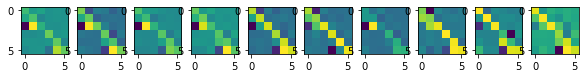

In [40]:
plt.figure(figsize=(10, 10))
S = inferred_Ms[checknet].to('cpu')
toshow=10
for k in range(toshow):
    plt.subplot(1, toshow, k+1)
    plt.imshow(S[k])

In [41]:
print(inferred_Ms[checknet].shape)
S = inferred_Ms[checknet].detach()
#STS = torch.matmul(S.transpose(-2, -1), S)
#STS[0] - S[0].transpose(0,1) @ S[0] 
print(S.shape)

torch.Size([10000, 6, 6])
torch.Size([10000, 6, 6])


In [42]:
# Is this method really working? 
from utils import optimize_bd_cob as obc
from importlib import reload
reload(obc)

Pmat = obc.optimize_bd_cob(S, epochs_monitor=10, n_epochs=50, lr=0.01)



ep:9 loss:2.98590983505249
ep:19 loss:2.9849178695678713
ep:29 loss:2.9844121486663817
ep:39 loss:2.984238501739502
ep:49 loss:2.984036897277832


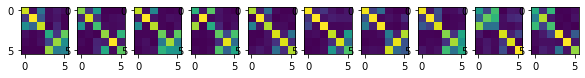

In [43]:
PSP = torch.abs(Pmat(S).detach().to('cpu'))
toshow = 10
plt.figure(figsize= (toshow, 1))
for k in range(toshow):
    plt.subplot(1, toshow, k+1)
    plt.imshow(PSP[k])

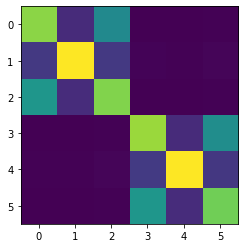

In [44]:
plt.imshow(torch.mean(torch.abs(PSP) , axis =0).detach())

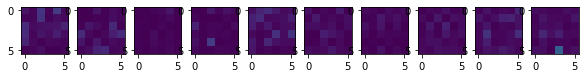

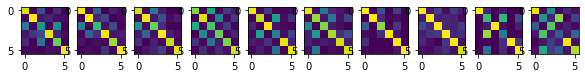

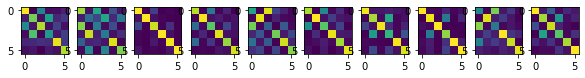

In [34]:
plt.figure(figsize=(10, 2))
pairs = []
for k in range(10):
    plt.subplot(1, 10, k+1)
    k0, k1 = np.random.choice(len(PSP), size=2)
    pairs.append([k0, k1])
    plt.imshow(torch.abs( PSP[k0] @ PSP[k1] -  PSP[k1] @ PSP[k0] ), vmin=0, vmax=1 )

plt.figure(figsize=(10, 2))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(torch.abs(PSP[pairs[k][0]] ), vmin=0, vmax=1 )

plt.figure(figsize=(10, 2))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(torch.abs(PSP[pairs[k][1]] ), vmin=0, vmax=1 )

In [52]:
dataconfig

{'args': {'T': 8,
  'data_filename': 'so3dat_sphere_Linear_shared_trans.pt',
  'datamode': 'so3',
  'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

In [53]:
datname = 'so3dat_sphere_Linear.pt'
dat_path = os.path.join(dat_root, datname)
#with open(dat_path, 'r') as f:
mydat = torch.load(dat_path) 
latent = mydat['latent']



In [54]:
myt = 4
idx = 0
mydat['trans'][idx][myt]

tensor([[ 0.1346,  0.9520, -0.2750,  0.0000,  0.0000,  0.0000],
        [ 0.8247,  0.0462,  0.5636,  0.0000,  0.0000,  0.0000],
        [ 0.5493, -0.3026, -0.7789,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.1463, -0.9488,  0.2799],
        [ 0.0000,  0.0000,  0.0000,  0.9864,  0.1612,  0.0309],
        [ 0.0000,  0.0000,  0.0000, -0.0744,  0.2716,  0.9595]])

In [28]:
model_configs[checknet]

{'args': {'ch_x': 1, 'dim_a': 6, 'dim_m': 10, 'k': 2.0, 'predictive': True},
 'fn': './models/seqae.py',
 'name': 'SeqAELSTSQ_LinearNet'}

# DEBUG if the transformation computed from trueinvnet, trueembed and true transformation agrees with the estimated transformation

In [29]:
invpath = os.path.join(dat_root, 'so3dat_sphere_Linear_model_invhat.pt') 
embedpath = os.path.join(dat_root, 'so3dat_sphere_Linear_model.pt') 
print(os.path.exists(embedpath))

checkmodel = copy.deepcopy(models[checknet])

# checkmodel.enc

dec_dict = torch.load(embedpath)
enc_dict = torch.load(invpath)

checkmodel.enc.load_state_dict(enc_dict, strict=False)
checkmodel.dec.load_state_dict(dec_dict, strict=False)

#         embed_fxn.load_state_dict(embed_dict, strict=False)

True


<All keys matched successfully>

In [43]:
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 3
n_cond = 5


    
Mlist = [] 
targdir_path = os.path.join(exp_result, targdir)
config = load_config(targdir_path)

dataconfig = config['train_data']
dataconfig['args']['T'] = tp + n_cond

data = yu.load_component(dataconfig)
train_loader = DataLoader(data, 
                      batch_size=config['batchsize'],
                      shuffle=True,
                      num_workers=config['num_workers'])
iterlist = iter_list(targdir_path)


maxiter = np.max(iter_list(targdir_path))
model = checkmodel.eval().to(device)

# Initialize lazy modules
images = iter(train_loader).next()
images = images.to(device)
model(images[:, :2])

with torch.no_grad():
    scores = [] 
    for idx, images in enumerate(train_loader):
        images = images.to(device)
        images_cond = images[:, :n_cond]
        images_target = images[:, n_cond:n_cond+tp]
        M = model.get_M(images_cond) #n a a
        H = model.encode(images_cond[:, -1:])[:, 0] # n s a
        
        xs = []
        for r in range(tp):
            H = H @ M 
            x_next_t = model.decode(H[:, None])
            xs.append(x_next_t)

        x_next = torch.cat(xs, axis=1)
        r2_losses = [] 
        for k in range(tp):
            r2_loss_t = r2_score(images_target[:,k].to('cpu').numpy(), x_next[:,k].to('cpu').numpy()) 
            r2_losses.append(r2_loss_t)
        scores.append(torch.tensor(r2_losses))
        Mlist.append(M)


Mlist = torch.cat(Mlist).to('cpu').detach()       
scores = torch.stack(scores)
av_score = torch.mean(scores, axis=0)
av_var = torch.var(scores, axis=0)
results_true_est = [av_score, av_var]
models['true'] = model.to('cpu')


    

In [44]:
results_true_est

[tensor([0.9938, 0.9834, 0.9773], dtype=torch.float64),
 tensor([2.3716e-06, 1.3744e-05, 2.3213e-05], dtype=torch.float64)]

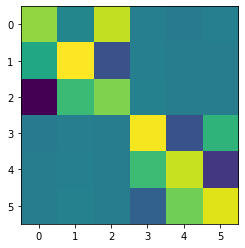

In [45]:
checkidx  = 0
plt.imshow(Mlist[checkidx].to('cpu').detach())

ep:0 loss:0.5872461443901063
ep:1 loss:0.5851141952991485
ep:2 loss:0.5833200106620788
ep:3 loss:0.5818956483840942
ep:4 loss:0.5828102076530457
ep:5 loss:0.5826812686920166
ep:6 loss:0.5819166193008423
ep:7 loss:0.5813127601623536
ep:8 loss:0.5806533292770386
ep:9 loss:0.5800217784881592


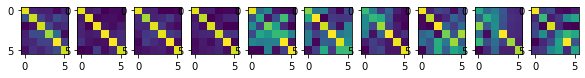

In [40]:
Pmat = obc.optimize_bd_cob(Mlist, epochs_monitor=1, n_epochs=10, lr=0.01)
PSP = torch.abs(Pmat(S).detach().to('cpu'))
toshow = 10
plt.figure(figsize= (toshow, 1))
for k in range(toshow):
    plt.subplot(1, toshow, k+1)
    plt.imshow(PSP[k])


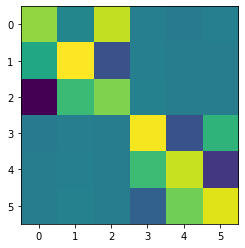

In [47]:
checkidx = 0
plt.imshow(Mlist[checkidx])

In [45]:
dataconfig

{'args': {'T': 8,
  'data_filename': 'so3dat_sphere_sine_shared_trans.pt',
  'datamode': 'so3',
  'pmatnet': None,
  'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}